<a href="https://colab.research.google.com/github/comparativechrono/Phase-oscillator-modelling-of-circadian-entrainment-in-transplanted-human-hearts/blob/main/Hearn_(2025)_Figure_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

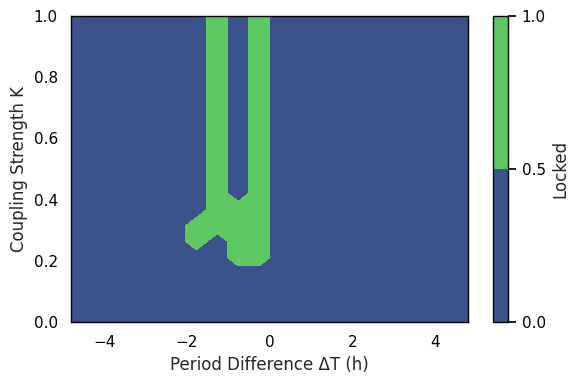

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import linregress
import seaborn as sns

# =============================================================================
# PRC INTERPOLATION
# =============================================================================
phase_hours = np.array([2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24])
shift_hours = np.array([1.0, 2.2, 2.5, 2.0, 1.0, -0.2, -1.5, -2.8, -3.5, -3.0, -1.0, 0.2])
phase_rad = phase_hours / 24 * 2 * np.pi
shift_rad = shift_hours / 24 * 2 * np.pi
interp_func = interp1d(phase_rad, shift_rad, kind='cubic', fill_value='extrapolate')
def Z(phi):
    return interp_func(phi % (2*np.pi))

# Intrinsic frequency
omega_H = 2 * np.pi / 24

# =============================================================================
# SIMULATION FUNCTION
# =============================================================================
def simulate_phase(omega_A, K, dt=0.5, tmax=150):
    ts = np.arange(0, tmax + dt, dt)
    phi = 0.0
    phis = np.zeros_like(ts)
    for i, t in enumerate(ts):
        dphi = omega_H + K * Z(phi) * np.sin(omega_A * t - phi)
        phi = (phi + dphi * dt) % (2 * np.pi)
        phis[i] = phi
    return ts, phis

# =============================================================================
# FREQUENCY ESTIMATION
# =============================================================================
def estimate_frequency(ts, phis):
    half = len(ts) // 2
    t_fit = ts[half:]
    phi_unwrapped = np.unwrap(phis[half:])
    cycles = phi_unwrapped / (2 * np.pi)
    slope, _, _, _, _ = linregress(t_fit, cycles)
    return slope  # cycles per hour

# =============================================================================
# ARNOLD TONGUE (FREQUENCY CRITERION)
# =============================================================================
Ks = np.linspace(0, 1, 20)
dWs = np.linspace(-0.2, 0.2, 20)
locked = np.zeros((len(Ks), len(dWs)), dtype=bool)

for i, K in enumerate(Ks):
    for j, dW in enumerate(dWs):
        omega_A = omega_H + dW
        ts, phis = simulate_phase(omega_A, K)
        f_H = estimate_frequency(ts, phis)
        f_A = omega_A / (2 * np.pi)
        locked[i, j] = abs(f_H / f_A - 1) < 0.02

# =============================================================================
# PLOT ARNOLD TONGUES
# =============================================================================
plt.figure(figsize=(6, 4))
plt.contourf(dWs * 24, Ks, locked, levels=[0, 0.5, 1], cmap='viridis')
plt.xlabel('Period Difference ΔT (h)')
plt.ylabel('Coupling Strength K')
plt.colorbar(label='Locked')
plt.tight_layout()
plt.savefig('Figure_4.png', dpi=300, bbox_inches='tight')
plt.show()
